# TODO

- [ ] Arrume o codigo
- [ ] Comente o codigo
- [ ] Passe as funções para um arquivo .py
- [ ] Deixe tudo parametrizvel em um arquivo de configs
- [ ] Passe para o cuda

In [1]:
import torch
import torch.nn as nn

In [2]:
from multi_head_attention import MultiHeadAttention
from feed_forward import FeedForward
from sinusoidal_positional_encoding import PositionalEncoding
from embedding import EmbeddingModel

In [3]:
class EncoderBlock(nn.Module):
    def __init__(
        self, 
        d_model: int, 
        n_heads: int,
        hidden_size: int,
        dropout: float = 0.1
    ):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.feed_forward = FeedForward(d_model, hidden_size, dropout)

        self.norm_mha = nn.LayerNorm(normalized_shape=d_model)
        self.norm_feed_forward = nn.LayerNorm(normalized_shape=d_model)

    def forward(self, x):
        x = self.norm_mha(x + self.mha(x, x, x))  # add & norm
        x = self.norm_feed_forward(x + self.feed_forward(x))  # add & norm
        return x

In [4]:
class TransformerEncoder(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        seq_len: int,
        d_model: int,
        nx: int,
        n_heads: int,
        hidden_size: int,
        dropout: float = 0.1
    ):
        super().__init__()
        self.embedding = nn.Sequential(
            EmbeddingModel(d_model, vocab_size),
            PositionalEncoding(d_model, seq_len, dropout=0.0)
        )
        self.encoder_blocks = nn.ModuleList(
            [
                EncoderBlock(
                    d_model,
                    n_heads,
                    hidden_size,
                    dropout=dropout,
                )
                for _ in range(nx)
            ]
        )

    def forward(self, x):
        x = self.embedding(x)
        for block in self.encoder_blocks:
            x = block(x)
        return x

In [5]:
x = torch.rand((2, 3)) * 100
x = x.int()

In [6]:
print(f"entrada teste")
print(x)
print(f"Shape entrada: {x.shape}")
print("-" * 30)

entrada teste
tensor([[77, 84, 94],
        [58, 45, 52]], dtype=torch.int32)
Shape entrada: torch.Size([2, 3])
------------------------------


In [7]:
encoder = TransformerEncoder(
    vocab_size=1000,
    seq_len=64,
    d_model=16,
    nx=2,
    n_heads=2,
    hidden_size=2
)

In [8]:
x_encoder = encoder(x)

In [9]:
print(f"Shape saida {x_encoder.shape}")

Shape saida torch.Size([2, 3, 16])


In [10]:
x_encoder

tensor([[[ 1.1000,  1.8747, -0.2661, -2.2156, -0.6271,  0.3488,  0.5775,
           1.4941, -0.7601,  0.1086, -0.0997, -0.2844, -0.6350,  0.7774,
          -1.2240, -0.1690],
         [ 1.3327,  0.7994, -0.7019, -2.7007,  0.3498, -0.3307, -0.1051,
           1.0632,  0.1669,  0.8494,  0.0476,  0.1294,  0.0873,  0.9576,
          -1.6209, -0.3240],
         [ 2.3348, -0.5803, -0.6401, -1.2201, -1.2163,  0.6870, -0.3742,
           0.6210,  0.1031,  1.2037,  0.6766, -0.8592, -0.5213,  1.2956,
          -0.9675, -0.5428]],

        [[-0.2591, -1.1178,  1.6305,  0.2642, -1.7796, -0.6754,  0.4287,
           1.4317, -0.7049,  1.1170,  0.1555, -0.2472,  0.6501,  1.2156,
          -0.7872, -1.3223],
         [ 0.1839,  1.8953, -1.0505, -1.1301,  0.2475, -0.9910, -0.0028,
           0.2854, -0.3251,  1.2047,  0.4050, -1.6762, -0.1216,  1.9754,
          -0.5392, -0.3605],
         [ 0.2535, -1.2092, -0.3562, -1.8290, -0.3222,  1.0495,  0.6653,
           1.6709, -0.6413,  1.3669,  1.0263, -1.4

# Criando o EncoderDataset para o pré treinamento

In [11]:
from tokenizer.Tokenizer import TokenizerImDB
from tokenizer.Tokenizer import SpecialTokensInt

In [12]:
SpecialTokensInt.tolist()

['PAD', 'CLS', 'UNK', 'MASK', 'SOS', 'EOS']

In [13]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

In [14]:
from pathlib import Path

In [15]:
import pandas as pd
import numpy as np

In [16]:
file = Path('../../data/imdb-reviews-pt-br.csv')
pd.read_csv(file)

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg
...,...,...,...,...
49454,49456,"Seeing as the vote average was pretty low, and...","Como a média de votos era muito baixa, e o fat...",pos
49455,49457,"The plot had some wretched, unbelievable twist...",O enredo teve algumas reviravoltas infelizes e...,pos
49456,49458,I am amazed at how this movieand most others h...,Estou espantado com a forma como este filme e ...,pos
49457,49459,A Christmas Together actually came before my t...,A Christmas Together realmente veio antes do m...,pos


In [17]:
tokenizer_path_pt = Path('tokenizer/artifacts/tokenizer_pt.json')

tokenizer_pt = TokenizerImDB(vocab_size=30_000, tokenizer_path=tokenizer_path_pt)

tokenizer_pt.encoder('ola')

[13344]

In [18]:
class EncoderPreTrainDataset(Dataset):
    def __init__(
        self,
        tokenizer: TokenizerImDB,
        seq_len: int,
        mask_prob: float,
        file_dataset: Path,
        language: str,
        mask_token_id: int = SpecialTokensInt.MASK.value,
        pad_token_id: int = SpecialTokensInt.PAD.value,
        special_tokens: list[int] = SpecialTokensInt.tolist(),
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.seq_len = seq_len
        self.mask_prob = mask_prob
        self.mask_token_id = mask_token_id
        self.pad_token_id = pad_token_id
        self.special_tokens = special_tokens
        self.vocab_size = tokenizer.vocab_size
        self.dataset = pd.read_csv(file_dataset)[f'text_{language}']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        text = self.dataset.iloc[index]
        text_tokens = self.tokenizer.encoder(text)
        if len(text_tokens) < self.seq_len:
            diff = self.seq_len - len(text_tokens)
            text_tokens += [self.pad_token_id for _ in range(diff)]
        elif len(text_tokens) > self.seq_len:
            text_tokens = text_tokens[: self.seq_len]

        text_tokens = torch.tensor(text_tokens)
        probs = torch.rand(text_tokens.shape)  # cria uma matriz de probas
        mask = (probs < self.mask_prob) * (text_tokens != self.pad_token_id)  # [True * True = 1], [True * False = 0], [False, False = 0]
        for special_token in self.special_tokens:
            mask = mask * (text_tokens != special_token)

        masked = torch.clone(text_tokens).type(torch.int)
        masked_ids = torch.flatten(mask.nonzero())  # -> retorna os ids que foram mascarados
        masked_ids_list = masked_ids.tolist()
        original_masked_tokens = text_tokens[masked_ids_list]  # -> retorna os verdadeiroas ids antes de serem substituidos por MASK
        replace_masked_tokens = self.generate_mlm_tokens(original_masked_tokens.tolist())
        masked[masked_ids_list] = replace_masked_tokens
        return masked, text_tokens, mask

    def generate_mlm_tokens(self, original_tokens: list[int]):
        len_original_tokens = len(original_tokens)
        replace_tokens = torch.rand(len_original_tokens)
        for i in range(len_original_tokens):
            if replace_tokens[i] <= 0.8:  # se esses caras forem menores do que 80% vira MASK
                replace_tokens[i] = self.mask_token_id
            elif 0.8 < replace_tokens[i] <= 0.9:
                replace_tokens[i] = np.random.randint(self.vocab_size)
            else:
                replace_tokens[i] = original_tokens[i]

        return replace_tokens.type(torch.int)

In [19]:
dataset = EncoderPreTrainDataset(
    tokenizer=tokenizer_pt,
    seq_len=64,
    mask_prob=0.15,
    file_dataset=Path('../../data/imdb-reviews-pt-br.csv'),
    language='pt'
)

In [20]:
len(dataset)

49459

In [21]:
X, y, mask = dataset[0]

In [22]:
class EncoderMLM(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        seq_len: int,
        d_model: int,
        nx: int,
        n_heads: int,
        hidden_size: int,
        dropout: float = 0.1
    ):
        super().__init__()
        self.d_model = d_model
        self.encoder = TransformerEncoder(
            vocab_size=vocab_size,
            seq_len=seq_len,
            d_model=d_model,
            nx=nx,
            n_heads=n_heads,
            hidden_size=hidden_size,
            dropout=0.1
        )

        self.mlm_head = nn.Linear(d_model, vocab_size)

    def forward(self, x, mask):
        # Nessa etapa atráves de codificação de MASK
        # Que é uma codificação que pega a representação dos tokens ao seu redor
        # Queremos prever qual é o token mais provavel para substituir o token MASK dado seu contexto
        # Esse contexto está representado no token MASK por isso usamos ele e depois passamos em um logit
        # O logit nos diz quel é o token mais provavel para substituir MASK
        # Não só MASK mas todos os tokens "errados" aleatórios que foram introduzidos

        # Gera as representações com encoder
        last_hidden_states = self.encoder(x)
        # reorganiza os tensores para facilitar a filtragem
        all_hidden_states = last_hidden_states.view(-1, self.d_model)
        # mask_flat = mask.view(-1)
        masked_ids = torch.flatten(mask.reshape((-1,)).nonzero())

        # filtra pelos tokens de mask ou aleatórios inseridos
        # masked_hidden_states = all_hidden_states[mask_flat.nonzero(as_tuple=True)].squeeze(1)
        masked_hidden_states = all_hidden_states[masked_ids, :]
        logits = self.mlm_head(masked_hidden_states)
        return logits

In [23]:
modelo = EncoderMLM(
    vocab_size=tokenizer_pt.vocab_size,
    seq_len=64,
    d_model=16,
    nx=3,
    n_heads=4,
    hidden_size=248,
)

In [24]:
x_ = modelo.encoder(x)
x_.shape

torch.Size([2, 3, 16])

In [25]:
x_

tensor([[[-0.3705,  0.1968, -1.6735,  1.9103, -1.0266,  0.7588, -1.1169,
           0.1121, -0.9457,  2.0030,  0.2467, -0.1753, -1.0254,  0.4636,
           0.4034,  0.2393],
         [ 1.1217,  0.1314,  0.5457,  0.0156, -0.4325,  0.9202, -1.0485,
           0.5676, -1.7066,  0.8031, -0.3209,  0.3140,  2.1991, -0.7199,
          -1.1624, -1.2273],
         [ 0.2023, -0.7511,  0.1729, -0.1268,  0.5565, -0.2205, -1.5829,
           0.7354, -1.0790,  2.1864, -1.6571,  1.1095,  0.3389,  0.5694,
          -1.0874,  0.6334]],

        [[ 0.0060,  0.2744, -0.9957,  1.0897,  0.9451,  0.0206, -1.3803,
          -0.2724, -1.7296,  2.4188, -0.0768,  1.1003, -0.4545,  0.0739,
          -0.3069, -0.7126],
         [ 1.2634, -1.6991, -0.9168,  0.0602, -0.0398, -0.1761, -0.7158,
           1.1460, -1.0347,  2.0712, -0.6021,  0.3756,  0.8105,  1.0280,
          -0.8259, -0.7447],
         [-0.8753,  0.3571, -2.3893,  0.4731,  0.0938,  1.3851,  0.8248,
           0.7989, -2.0363,  1.0801,  0.1495,  0.4

In [26]:
# pq o adamW
optimizer = torch.optim.AdamW(modelo.parameters(), lr=5e-5, weight_decay=1e-5)
dataloader = torch.utils.data.DataLoader(
    dataset, num_workers=8, shuffle=True, batch_size=1
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [27]:
X, y, masked_mask = next(iter(dataloader))

In [28]:
(X != y).sum()

tensor(9)

In [29]:
y

tensor([[   45,   652,   296,   192,   900,   790,   132,  2908,    18,  6411,
           122,   132,  2466,   140,   240,   188,  5008,    16,  1328,   259,
           188,   206, 12290,   125,   346,    18,   269,   970,   629,   180,
           166,   613,   122,   727,   180,  1022,    18,   202,   157,  2556,
           579,   400,   180,  1022,    16,   224,   164,  1079,   441,   277,
           378,   691,   574,    18,  3091,  2523,   970,  5948,   192,   296,
           277,   122,  2047, 14929]])

In [30]:
X

tensor([[   45,   652,   296,   192,   149,   790,   132,  2908,    18,  6411,
           122,   132,  2466,   140,   240,   188,  5008,    16,  1328,   259,
           188,   206, 12290,   125,   346,    18,   269,   970,   629,   180,
           166,   613,     3,   727,   180,  1022,    18,     3,   157,  2556,
           579,   400,   180,  1022,     3,   224,   164,  1079,   441,   277,
             3,   691,   574,    18,     3, 14486,     3,  5948,     3,   296,
           277,   122,  2047, 14929]], dtype=torch.int32)

In [31]:
masked_mask

tensor([[False, False, False, False,  True, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False,  True, False, False,
         False, False, False, False,  True, False, False, False, False, False,
          True, False, False, False,  True,  True,  True, False,  True, False,
         False, False, False, False]])

In [32]:
masked_mask.sum()

tensor(10)

In [33]:
X

tensor([[   45,   652,   296,   192,   149,   790,   132,  2908,    18,  6411,
           122,   132,  2466,   140,   240,   188,  5008,    16,  1328,   259,
           188,   206, 12290,   125,   346,    18,   269,   970,   629,   180,
           166,   613,     3,   727,   180,  1022,    18,     3,   157,  2556,
           579,   400,   180,  1022,     3,   224,   164,  1079,   441,   277,
             3,   691,   574,    18,     3, 14486,     3,  5948,     3,   296,
           277,   122,  2047, 14929]], dtype=torch.int32)

In [34]:
y

tensor([[   45,   652,   296,   192,   900,   790,   132,  2908,    18,  6411,
           122,   132,  2466,   140,   240,   188,  5008,    16,  1328,   259,
           188,   206, 12290,   125,   346,    18,   269,   970,   629,   180,
           166,   613,   122,   727,   180,  1022,    18,   202,   157,  2556,
           579,   400,   180,  1022,    16,   224,   164,  1079,   441,   277,
           378,   691,   574,    18,  3091,  2523,   970,  5948,   192,   296,
           277,   122,  2047, 14929]])

In [35]:
out = modelo(X, masked_mask)

In [36]:
masked_ids = torch.flatten(masked_mask.reshape((-1,)).nonzero())
labels = y.reshape((-1,))[masked_ids]
labels

tensor([ 900, 6411,  122,  202,   16,  378, 3091, 2523,  970,  192])

In [37]:
loss = nn.functional.cross_entropy(out, labels)

In [38]:
labels

tensor([ 900, 6411,  122,  202,   16,  378, 3091, 2523,  970,  192])

In [39]:
out

tensor([[-0.1136,  1.3910, -0.2926,  ..., -0.7039,  0.9807, -0.5853],
        [ 0.8407, -1.0891, -0.2660,  ..., -0.1534, -0.0517,  0.3821],
        [-0.5328,  0.6517,  0.4509,  ...,  0.5147, -0.5713, -0.0596],
        ...,
        [-0.2306,  1.0034,  0.5547,  ...,  0.8560, -0.5888,  0.2904],
        [-0.5904,  0.7057,  0.8223,  ...,  1.1075, -0.1957, -0.5652],
        [-0.5611,  0.5095,  0.9263,  ...,  0.8239, -0.5105, -0.1186]],
       grad_fn=<AddmmBackward0>)

In [40]:
out[torch.arange(out.size(0)), labels]

tensor([-0.5010, -0.1019,  0.5273, -0.4180, -0.7453, -0.6043,  0.1397,  0.6942,
        -0.3069, -0.1353], grad_fn=<IndexBackward0>)

In [41]:
loss

tensor(10.6234, grad_fn=<NllLossBackward0>)

In [42]:
from collections import defaultdict
import matplotlib.pyplot as plt

In [43]:
len(dataloader)

49459

In [44]:
loss_list = defaultdict(list)
mean_loss_per_epoch = []
EPOCHS = 3
c = 0
for epoch in range(EPOCHS):
    epoch_loss = 0
    for X, y, masked_mask in dataloader:
        masked_ids = torch.flatten(masked_mask.reshape((-1,)).nonzero())
        labels = y.reshape((-1,))[masked_ids]
        out = modelo(X, masked_mask)
        loss = torch.nn.functional.cross_entropy(out, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        print(f'\r{c}/{len(dataloader)} | {epoch}', end='', flush=True)
        loss_list[epoch].append(loss.item())
        epoch_loss += loss.item()
        c += 1
    mean_loss = epoch_loss / len(dataloader)
    mean_loss_per_epoch.append(mean_loss)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


148376/49459 | 2

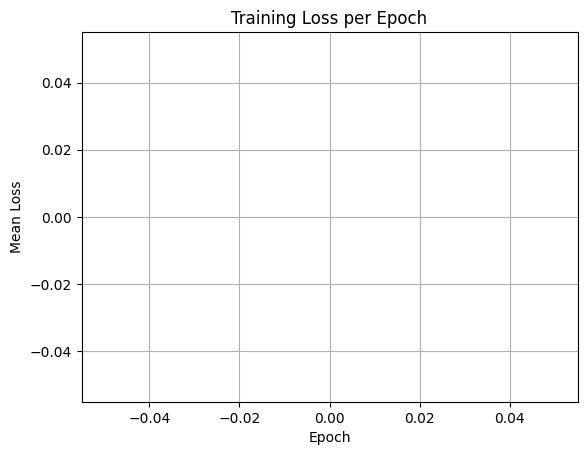

In [45]:
plt.plot(range(1, EPOCHS+1), mean_loss_per_epoch, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Loss')
plt.title('Training Loss per Epoch')
plt.grid()
plt.show()

In [65]:
clean_loss_list_0 = [x for x in loss_list[0] if not (np.isnan(x) or np.isinf(x))]

In [61]:
clean_loss_list_1 = [x for x in loss_list[1] if not (np.isnan(x) or np.isinf(x))]
clean_loss_list_2 = [x for x in loss_list[2] if not (np.isnan(x) or np.isinf(x))]

In [60]:
np.mean(clean_loss_list)

7.069114771301358

In [62]:
np.mean(clean_loss_list_1)

6.747537355264179

In [63]:
np.mean(clean_loss_list_2)

6.674247748332536

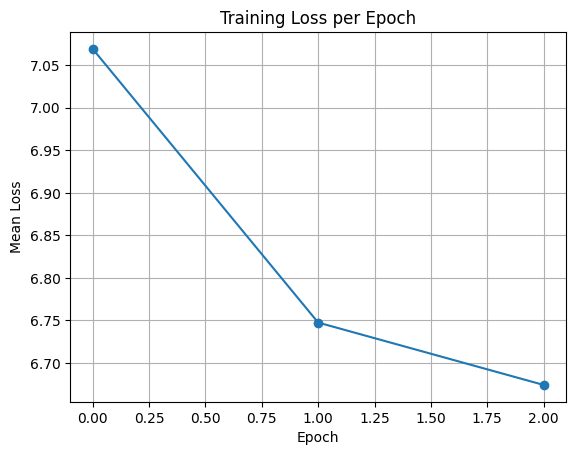

In [68]:
plt.plot([np.mean(clean_loss_list_0), np.mean(clean_loss_list_1), np.mean(clean_loss_list_2)], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Mean Loss')
plt.title('Training Loss per Epoch')
plt.grid()
plt.show()